In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, test, save, load

import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

2025-04-17 08:59:44.870 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


## Load data

In [3]:
from torchvision import models
from torchvision.transforms import Compose, Resize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize

# Define preprocessing pipeline
train_transform = Compose([
    Resize((256, 256)),
    RandomCrop((224, 224)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

eval_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

In [4]:
train_dataloader = DataLoader(cifar100_train)
test_dataloader = DataLoader(cifar100_test)

In [5]:
# # Stack all images into a single tensor
# all_images = torch.cat([cifar100_train[i][0].unsqueeze(0) for i in range(len(cifar100_train))], dim=0)

# print(all_images.shape)

# # Calculate mean and std for each channel (RGB)
# mean = all_images.mean(dim=(0, 2, 3))  # Mean across batch, height, and width
# std = all_images.std(dim=(0, 2, 3))    # Std across batch, height, and width

# print(f"Mean: {mean}")
# print(f"Std: {std}")

## Train Model

Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


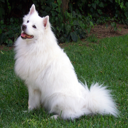

Predicted label: grey wolf


In [6]:
import requests
from IPython.display import display
from PIL import Image

# Load the pretrained DINO ViT-S/16 model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
model.eval()  # Set the model to evaluation mode

# Download a sample image from ImageNet
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB")
display(img.resize((128, 128)))

imagenet_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image
input_tensor = imagenet_transform(img).unsqueeze(0)  # Add batch dimension

# Move to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Load ImageNet class labels
imagenet_classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_classes = requests.get(imagenet_classes_url).json()

# Get the predicted label string
predicted_label = output.argmax(dim=1).item()
predicted_label_str = imagenet_classes[predicted_label]
print("Predicted label:", predicted_label_str)

In [10]:
# Load model from torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
model.head = nn.Sequential(
    Linear(384, 1024),
    nn.ReLU(),
    Linear(1024, 1024),
    nn.ReLU(),
    Linear(1024, 1024),
    nn.ReLU(),
    Linear(1024, 1024),
    nn.ReLU(),
    Linear(1024, 100),
)
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

model.head.apply(initialize_weights)

# Freeze whole model
for param in model.parameters():
    param.requires_grad = False

# Allow to access some of the blocks
for param in model.blocks[-4:].parameters():
    param.requires_grad = True

# Also allow the LayerNorm
for param in model.norm.parameters():
    param.requires_grad = True

# And obviously the head (MLP)
for param in model.head.parameters():
    param.requires_grad = True

model.to(device)

Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Sequential(
   

In [11]:
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"

# Parameters
batch_size = 128
start_epoch = 1
num_epochs = 50
save_every = 5

# Optimizer and loss
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = torch.nn.CrossEntropyLoss()

# Train
train(
    checkpoint_dir=CHECKPOINT_DIR,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    criterion=criterion,
    start_epoch=start_epoch,
    num_epochs=num_epochs,
    save_every=save_every,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    prefix=None,
    verbose=True,
)

  ↳ Batch 1/50000 | Loss: 16.3136 | Batch Acc: 0.00%
  ↳ Batch 2/50000 | Loss: 45.3658 | Batch Acc: 0.00%
  ↳ Batch 3/50000 | Loss: 25.4818 | Batch Acc: 0.00%
  ↳ Batch 4/50000 | Loss: 47.5522 | Batch Acc: 0.00%
  ↳ Batch 5/50000 | Loss: 43.3530 | Batch Acc: 0.00%
  ↳ Batch 6/50000 | Loss: 34.6616 | Batch Acc: 0.00%
  ↳ Batch 7/50000 | Loss: 23.9285 | Batch Acc: 0.00%
  ↳ Batch 8/50000 | Loss: 20.4467 | Batch Acc: 0.00%
  ↳ Batch 9/50000 | Loss: 26.1697 | Batch Acc: 0.00%
  ↳ Batch 10/50000 | Loss: 18.8569 | Batch Acc: 0.00%
  ↳ Batch 11/50000 | Loss: 14.1772 | Batch Acc: 0.00%
  ↳ Batch 12/50000 | Loss: 19.3450 | Batch Acc: 0.00%
  ↳ Batch 13/50000 | Loss: 16.4669 | Batch Acc: 0.00%
  ↳ Batch 14/50000 | Loss: 14.4107 | Batch Acc: 0.00%
  ↳ Batch 15/50000 | Loss: 12.8102 | Batch Acc: 0.00%
  ↳ Batch 16/50000 | Loss: 15.5768 | Batch Acc: 0.00%
  ↳ Batch 17/50000 | Loss: 16.7567 | Batch Acc: 0.00%
  ↳ Batch 18/50000 | Loss: 12.1008 | Batch Acc: 0.00%
  ↳ Batch 19/50000 | Loss: 13.7586 | 

KeyboardInterrupt: 